### Pipeline Classification Binaire

L'objectif de ce notebook est d'expérimenter avec divers modèles pour résoudre une tâche de classification binaire. 
Plus précisément, nous cherchons à prédire à partir des données lors d'un demarragge d'un job, quel type de criticité est susceptible de survenenir à savoir; 
- Info (pas d'erreur - false)
- Warning (pas d'erreur - false)
- Error (erreur - true)
- Aucun (pas d'erreur - false)

Ce model sera le premier d'une paire de model ayant comme objectif de predire un type d'erreur précis. 
Si ce model predit une erreur, le deuxième model predira le type d'erreur que nous allons rencontré.

### Importation des bibliothèques et des modules nécessaires.
Ce code représente la section où les bibliothèques et les modules nécessaires sont importés. Les bibliothèques telles que pandas, numpy, sklearn, seaborn, matplotlib, imblearn et mlflow sont importées pour effectuer différentes tâches liées à l'apprentissage automatique et à l'analyse de données. Les modules spécifiques tels que StandardScaler, LabelEncoder, RandomForestClassifier, LogisticRegression, etc. sont importés pour utiliser des fonctionnalités spécifiques de ces modèles d'apprentissage automatique.

In [79]:
import pandas as pd
import numpy as np
import random


from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV,learning_curve

from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, roc_curve, auc , roc_auc_score,make_scorer, precision_score, f1_score


from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

from lightgbm import LGBMClassifier
# ---------------------------------------------------
# Windows users need to install Visual C++ Redistributable

# XGBoost requires DLLs from Visual C++ Redistributable in order to function, so make sure to install it. 
# Exception: If you have Visual Studio installed, you already have access to necessary libraries and thus don’t need to install Visual C++ Redistributable.
from xgboost import XGBClassifier
# ---------------------------------------------------

import mlflow
import mlflow.sklearn
from joblib import dump, load
import json

### Ci-dessous plusieurs étapes d'importation et d'analyse des données

In [80]:
# nom de fichier et chemin relatif
filename = 'merged_printers_data_criticality.csv'
path = './data/'
# création d'un dataframe à partir du csv de données
df = pd.read_csv(path+filename, index_col=0)
df.head(2)

,speed,paperHeight_job,paperWidth_job,total_copies_requested,ifoil,scanner_mode,bars_job,varnishConsumptionVarnish_3d_job,LED,drops,...,y_imageLayout,power_irDryers,power_uvDryers,redScore_gridMode_remoteScannerRegistration,redScore_cropmarksMode_remoteScannerRegistration,redScore_fullScannerMode_remoteScannerRegistration,blueScore_fullScannerMode_remoteScannerRegistration,greenScore_fullScannerMode_remoteScannerRegistration,criticality_events,machineID
duration,,,,,,,,,,,,,,,,,,,,,
171.889,700,520,740,2,False,1,1,0.059481,10,1,...,0,45,100,1500,1500,1500,16,16,INFO,14
171.889,700,520,740,2,False,1,1,0.059481,10,1,...,0,45,100,1500,1500,1500,16,16,INFO,14


In [81]:
df.shape

(90989, 24)

In [82]:
df.columns

Index(['speed', 'paperHeight_job', 'paperWidth_job', 'total_copies_requested',
       'ifoil', 'scanner_mode', 'bars_job', 'varnishConsumptionVarnish_3d_job',
       'LED', 'drops', 'speed_ifoil', 'heater1Enabled_ifoil',
       'heater1Temperature_ifoil', 'x_imageLayout', 'y_imageLayout',
       'power_irDryers', 'power_uvDryers',
       'redScore_gridMode_remoteScannerRegistration',
       'redScore_cropmarksMode_remoteScannerRegistration',
       'redScore_fullScannerMode_remoteScannerRegistration',
       'blueScore_fullScannerMode_remoteScannerRegistration',
       'greenScore_fullScannerMode_remoteScannerRegistration',
       'criticality_events', 'machineID'],
      dtype='object')

In [83]:
df['criticality_events'].unique()

array(['INFO', 'ERROR', 'WARNING', 'NO_EVENT'], dtype=object)

In [84]:
df['criticality_events'].nunique()

4

In [85]:
df['criticality_events'].value_counts() 

INFO        26231
ERROR       26231
NO_EVENT    25557
WARNING     12970
Name: criticality_events, dtype: int64

----

In [86]:
df.drop('machineID',axis=1,inplace=True)

# Sous-échantillonnage / Sur-échantillonnage

In [87]:
balanced_method = "under-sampling"
# choisir entre "under-sampling", "over-sampling" and "no-balancing"


if balanced_method == "under-sampling":
    # Obtenir le nombre minimum d'instances parmi les classes
    min_class_count = df['criticality_events'].value_counts()['ERROR']  # Nombre d'instances dans la classe minoritaire ERROR

    # Pour chaque classe non-ERROR, sous-échantillonner pour obtenir min_class_count instances
    balanced_df = pd.DataFrame()
    for class_name in ['INFO', 'NO_EVENT', 'WARNING']:
        class_subset = df[df['criticality_events'] == class_name]
        sampled_subset = class_subset.sample(min(min_class_count, len(class_subset)), random_state=42) 
        balanced_df = pd.concat([balanced_df, sampled_subset], axis=0)
    

   # Ajouter les instances ERROR sans changement
    df_error = df[df['criticality_events'] == 'ERROR']
    balanced_df = pd.concat([balanced_df, df_error], axis=0)

    # Mélanger le DataFrame final
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index()

    # Remplacer le DataFrame original par le DataFrame équilibré
    df = balanced_df

    # Créer une nouvelle colonne 'binary_class' avec des valeurs booléennes
    df['error'] = df['criticality_events'].apply(lambda x: True if x == 'ERROR' else False)

    # Séparez les données en deux DataFrames, un pour chaque classe
    df_error = df[df['error'] == True]
    df_non_error = df[df['error'] == False]

    # Pour équilibrer les classes, divisez la classe 'NON_ERROR' en trois et prenez une partie
    # La méthode sample de pandas est utilisée pour générer un échantillon aléatoire d'éléments à partir de notre ensemble de données. 
    df_non_error = df_non_error.sample(len(df_non_error)//3, random_state=42)

    # Fusionner les deux DataFrames en un seul
    df = pd.concat([df_error, df_non_error], axis=0)

    print(df['criticality_events'].value_counts())

    info_count = df['criticality_events'].value_counts()['INFO']
    error_count = df['criticality_events'].value_counts()['ERROR']
    no_event_count = df['criticality_events'].value_counts()['NO_EVENT']
    warning_count = df['criticality_events'].value_counts()['WARNING']

    df.drop(columns='criticality_events', inplace=True)
    
    # Séparation des données avec train_test_split
    X = df.drop('error', axis=1)
    y = df['error']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=random.randint(0, 100))


    # fusion des test set pour l'input json
    example_input = pd.concat([X_test, y_test], axis=1)

    # 1. Sélectionner les dernières lignes de `example_input` pour un exemple d'entrée MLFLOW
    last_rows_example = example_input.iloc[-5:]

    # Créer un objet JSON en utilisant les lignes et noms de colonnes originaux
    example_input_json = last_rows_example.to_dict('records')

    # Recombiner les deux DataFrames
    df_balanced = pd.concat([df_error, df_non_error], axis=0)


    # On reset l'index sinon la duration est l'index
    df.reset_index(inplace=True)

    # Mélanger les données
    df = df_balanced.sample(frac=1, random_state=42)

    true_count = y_train[y_train == True].shape[0]
    false_count = y_train[y_train == False].shape[0]


    sampling_info = (
    "Sous-échantillonnage réalisé pour équilibrer les classes. "
    "Distribution initiale : INFO: {}, ERROR: {}, NO_EVENT: {}, WARNING: {}. "
    "Chaque classe a été réduite à {} échantillons, correspondant au nombre dans la classe 'WARNING'. "
    "Les classes 'INFO', 'NO_EVENT' et 'WARNING' ont été fusionnées en une classe 'FALSE' (pas d'erreur), "
    "et la classe 'ERROR' a été renommée 'TRUE' (erreur), résultant en deux nouvelles classes plus équilibrées : "
    "'TRUE': {} et 'FALSE': {}.").format(
        info_count, error_count, no_event_count, warning_count,
        warning_count, true_count, false_count)

    do_smote = False


elif balanced_method == "over-sampling":
    # Si cette option est choisie, les classes seront équilibrées en utilisant SMOTE plus bas dans le notebook
    # Créer une nouvelle colonne 'binary_class' avec des valeurs booléennes

    df['error'] = df['criticality_events'].apply(lambda x: True if x == 'ERROR' else False)

    print(df['criticality_events'].value_counts())

    info_count = df['criticality_events'].value_counts()['INFO']
    error_count = df['criticality_events'].value_counts()['ERROR']
    no_event_count = df['criticality_events'].value_counts()['NO_EVENT']
    warning_count = df['criticality_events'].value_counts()['WARNING']

    df.drop(columns='criticality_events', inplace=True)

    # On reset l'index sinon la duration est l'index
    df.reset_index(inplace=True)

    df = df.sample(frac=1, random_state=42)
   
    # Séparation des données avec train_test_split
    X = df.drop('error', axis=1)
    y = df['error']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=random.randint(0, 100))

    # fusion des test set pour l'input json
    example_input = pd.concat([X_test, y_test], axis=1)

    # Sélectionner les dernières lignes de `example_input` pour un exemple d'entrée MLFLOW
    last_rows_example = example_input.iloc[-5:]

    # Créer un objet JSON en utilisant les lignes et noms de colonnes originaux
    example_input_json = last_rows_example.to_dict('records')

    true_count = y_train[y_train == True].shape[0]
    false_count = y_train[y_train == False].shape[0]

    
    do_smote = True

else:
    balanced_method = "no-balancing"
     # Créer une nouvelle colonne 'binary_class' avec des valeurs booléennes
    df['error'] = df['criticality_events'].apply(lambda x: True if x == 'ERROR' else False)
   
    print(df['criticality_events'].value_counts())

    info_count = df['criticality_events'].value_counts()['INFO']
    error_count = df['criticality_events'].value_counts()['ERROR']
    no_event_count = df['criticality_events'].value_counts()['NO_EVENT']
    warning_count = df['criticality_events'].value_counts()['WARNING']

    df.drop(columns='criticality_events', inplace=True)

    # On reset l'index sinon la duration est l'index
    df.reset_index(inplace=True)

    # Mélanger les données
    df = df.sample(frac=1, random_state=42)

    # Séparation des données avec train_test_split
    X = df.drop('error', axis=1)
    y = df['error']


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=random.randint(0, 100))


    # fusion des test set pour l'input json
    example_input = pd.concat([X_test, y_test], axis=1)

    # Sélectionne les dernières lignes de `example_input` pour un exemple d'entrée MLFLOW
    last_rows_example = example_input.iloc[-5:]

    # Créer un objet JSON en utilisant les lignes et noms de colonnes originaux
    example_input_json = last_rows_example.to_dict('records')

    true_count = y_train[y_train == True].shape[0]
    false_count = y_train[y_train == False].shape[0]

    sampling_info = ("Aucun équilibrage des classes n'a été effectué. Les classes sont laissées dans leur état d'origine déséquilibré. "
    "Distribution initiale : INFO: {}, ERROR: {}, NO_EVENT: {}, WARNING: {}. "
    "Les classes 'INFO', 'NO_EVENT' et 'WARNING' ont été fusionnées en une classe 'FALSE' (pas d'erreur), "
    "et la classe 'ERROR' a été renommée 'TRUE' (erreur), résultant en deux nouvelles classes déséquilibrées : "
    "'TRUE': {} et 'FALSE': {}.").format(
        info_count, error_count, no_event_count, warning_count,
        warning_count, true_count, false_count)


    do_smote = False



total_size = len(X)  # Taille totale avant SMOTE
test_size_percentage = len(X_test) / total_size

print('------------------')
print(df['error'].value_counts())
print(y_test.value_counts())
print('------------------')


ERROR       26231
INFO         8703
NO_EVENT     8502
WARNING      4381
Name: criticality_events, dtype: int64
------------------
True     26231
False    21586
Name: error, dtype: int64
True     3893
False    3280
Name: error, dtype: int64
------------------


In [88]:
df.head(5)

,duration,speed,paperHeight_job,paperWidth_job,total_copies_requested,ifoil,scanner_mode,bars_job,varnishConsumptionVarnish_3d_job,LED,...,y_imageLayout,power_irDryers,power_uvDryers,redScore_gridMode_remoteScannerRegistration,redScore_cropmarksMode_remoteScannerRegistration,redScore_fullScannerMode_remoteScannerRegistration,blueScore_fullScannerMode_remoteScannerRegistration,greenScore_fullScannerMode_remoteScannerRegistration,criticality_events,error
43461,304.671,251,483,330,51,True,3,1,0.820739,50,...,-16,20,65,1500,1500,1500,24,25,NO_EVENT,False
6040,1614.500,307,520,740,200,False,1,2,54.324061,10,...,0,45,100,3135,3135,3135,10,10,INFO,False
22435,87.943,251,483,330,10,True,2,1,0.775865,50,...,14,45,70,4000,4000,4000,20,20,INFO,False
85022,243.966,313,520,740,125,False,1,2,5.309839,30,...,0,45,100,3135,3135,3135,11,10,ERROR,True
22517,135.426,700,920,650,2,False,1,1,0.968331,10,...,0,45,100,2348,2348,2348,16,19,INFO,False


In [89]:
try:
    print(df_non_error['error'].value_counts())
except:
    pass

False    21586
Name: error, dtype: int64


In [90]:
df.head(2)

,duration,speed,paperHeight_job,paperWidth_job,total_copies_requested,ifoil,scanner_mode,bars_job,varnishConsumptionVarnish_3d_job,LED,...,y_imageLayout,power_irDryers,power_uvDryers,redScore_gridMode_remoteScannerRegistration,redScore_cropmarksMode_remoteScannerRegistration,redScore_fullScannerMode_remoteScannerRegistration,blueScore_fullScannerMode_remoteScannerRegistration,greenScore_fullScannerMode_remoteScannerRegistration,criticality_events,error
43461,304.671,251,483,330,51,True,3,1,0.820739,50,...,-16,20,65,1500,1500,1500,24,25,NO_EVENT,False
6040,1614.500,307,520,740,200,False,1,2,54.324061,10,...,0,45,100,3135,3135,3135,10,10,INFO,False


In [91]:
df.dtypes

duration                                                float64
speed                                                     int64
paperHeight_job                                           int64
paperWidth_job                                            int64
total_copies_requested                                    int64
ifoil                                                      bool
scanner_mode                                              int64
bars_job                                                  int64
varnishConsumptionVarnish_3d_job                        float64
LED                                                       int64
drops                                                     int64
speed_ifoil                                             float64
heater1Enabled_ifoil                                       bool
heater1Temperature_ifoil                                  int64
x_imageLayout                                             int64
y_imageLayout                           

In [92]:
df.head()

,duration,speed,paperHeight_job,paperWidth_job,total_copies_requested,ifoil,scanner_mode,bars_job,varnishConsumptionVarnish_3d_job,LED,...,y_imageLayout,power_irDryers,power_uvDryers,redScore_gridMode_remoteScannerRegistration,redScore_cropmarksMode_remoteScannerRegistration,redScore_fullScannerMode_remoteScannerRegistration,blueScore_fullScannerMode_remoteScannerRegistration,greenScore_fullScannerMode_remoteScannerRegistration,criticality_events,error
43461,304.671,251,483,330,51,True,3,1,0.820739,50,...,-16,20,65,1500,1500,1500,24,25,NO_EVENT,False
6040,1614.500,307,520,740,200,False,1,2,54.324061,10,...,0,45,100,3135,3135,3135,10,10,INFO,False
22435,87.943,251,483,330,10,True,2,1,0.775865,50,...,14,45,70,4000,4000,4000,20,20,INFO,False
85022,243.966,313,520,740,125,False,1,2,5.309839,30,...,0,45,100,3135,3135,3135,11,10,ERROR,True
22517,135.426,700,920,650,2,False,1,1,0.968331,10,...,0,45,100,2348,2348,2348,16,19,INFO,False


In [93]:
# # Encodage de la colonne 'y' avec LabelEncoder
# encoder = LabelEncoder()
# df['criticality_events'] = encoder.fit_transform(df['criticality_events'])

In [94]:
example_input.head()

,duration,speed,paperHeight_job,paperWidth_job,total_copies_requested,ifoil,scanner_mode,bars_job,varnishConsumptionVarnish_3d_job,LED,...,x_imageLayout,y_imageLayout,power_irDryers,power_uvDryers,redScore_gridMode_remoteScannerRegistration,redScore_cropmarksMode_remoteScannerRegistration,redScore_fullScannerMode_remoteScannerRegistration,blueScore_fullScannerMode_remoteScannerRegistration,greenScore_fullScannerMode_remoteScannerRegistration,error
59622,252.686,313,483,330,56,True,2,2,2.130709,50,...,1490,-15,20,50,4000,4000,4000,24,25,False
18046,66.169,446,646,456,1,False,3,2,0.479120,10,...,595,0,50,95,1500,1500,1500,16,16,False
16185,60.618,418,483,330,4,True,2,2,0.119910,50,...,1488,0,20,50,4000,4000,4000,24,25,True
59275,143.599,313,520,740,2,False,1,2,1.997933,30,...,70,0,45,100,2561,2561,2561,10,11,False
58398,70.439,251,483,330,6,True,3,1,0.340619,50,...,1512,-16,20,65,1500,1500,1500,24,25,False


In [95]:
# True pour utiliser StandardScaler, False pour utiliser MinMaxScaler
use_standard_scaler = True

if use_standard_scaler:
    scaler = StandardScaler()
    scaler_used = "StandardScaler a été utilisé sur ce run pour standardiser les données de type numérique"
else:
    scaler = MinMaxScaler()
    scaler_used = "MinMaxScaler a été utilisé sur ce run pour standardiser les données de type numérique"


# Sélectionnez uniquement les colonnes de type float64 pour la normalisation
num_columns = [col for col, col_type in X_train.dtypes.items() if col_type in ['float64','int64']]

# Ajustez le scaler sur X_train  pour transformer X_train
X_train[num_columns] = scaler.fit_transform(X_train[num_columns])

# Utilisez le scaler ajusté pour transformer X_test
X_test[num_columns] = scaler.transform(X_test[num_columns])

In [96]:
y_train.value_counts()

True     22338
False    18306
Name: error, dtype: int64

In [97]:
X_train.columns

Index(['duration', 'speed', 'paperHeight_job', 'paperWidth_job',
       'total_copies_requested', 'ifoil', 'scanner_mode', 'bars_job',
       'varnishConsumptionVarnish_3d_job', 'LED', 'drops', 'speed_ifoil',
       'heater1Enabled_ifoil', 'heater1Temperature_ifoil', 'x_imageLayout',
       'y_imageLayout', 'power_irDryers', 'power_uvDryers',
       'redScore_gridMode_remoteScannerRegistration',
       'redScore_cropmarksMode_remoteScannerRegistration',
       'redScore_fullScannerMode_remoteScannerRegistration',
       'blueScore_fullScannerMode_remoteScannerRegistration',
       'greenScore_fullScannerMode_remoteScannerRegistration'],
      dtype='object')

### Suréchantillonage

In [98]:
# Création d'une instance de l'objet SMOTE.
# SMOTE est une technique de suréchantillonnage qui fonctionne en créant des instances synthétiques des classes minoritaires.
# Ces instances sont créées en sélectionnant un nombre k (par défaut k=5) de voisins les plus proches dans l'espace des caractéristiques pour une instance donnée,
# et en créant une nouvelle instance qui se situe le long des lignes reliant cette instance à ses voisins.
# L'utilisation d'un random_state spécifique garantit que le suréchantillonnage sera toujours le même si vous exécutez à nouveau ce code.
if do_smote == True:
    smote = SMOTE(k_neighbors=3,random_state=42)

    # Application de la méthode SMOTE à nos données.
    # Cela crée de nouvelles instances synthétiques des classes minoritaires, ce qui devrait aider à équilibrer les classes.
    # Le résultat est un nouvel ensemble de données X et un nouvel ensemble de labels y  qui contiennent les instances originales 
    # plus les nouvelles instances synthétiques.
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Sauvegarder le schéma d'entrée et de sortie pour le modèle
    input_schema = str(X_train.dtypes)
    output_schema = str(y_train.dtypes)
    data_augmentation_done = True
    print(y_train.value_counts())

    false_count_smote = y_train[y_train == False].shape[0]

    total_size = len(X_train) + len(X_test)
    test_size_percentage = len(X_test) / total_size
    
    sampling_info = ("Sur-échantillonnage réalisé pour équilibrer les classes. "
                 "Distribution initiale : INFO: {}, ERROR: {}, NO_EVENT: {}, WARNING: {}. "
                 "2 classes ont été augmenté à {} échantillons, correspondant au nombre des classes majoritaire 'INFO' et 'ERROR'. "
                 "Les classes 'INFO', 'NO_EVENT' et 'WARNING' ont été fusionnées en une classe 'FALSE' (pas d'erreur), "
                 "et la classe 'ERROR' a été renommée 'TRUE' (erreur), résultant en deux nouvelles classes équilibrées : "
                 "'TRUE': {} et 'FALSE': {} ({} pour les 2 classes avec SMOTE pour le jeu d'entrainement)").format(
                     info_count, error_count, no_event_count, warning_count, 
                     warning_count, true_count, false_count, false_count_smote)
else:
    input_schema = str(X_train.dtypes)
    output_schema = str(y_train.dtypes)
    data_augmentation_done = False
    print(y_train.value_counts())

    total_size = len(X_train) + len(X_test)
    test_size_percentage = len(X_test) / total_size
    # Convertir le schéma d'entrée et de sortie en JSON pour MLflow et les sauvegarder en artefact , 
    # le schéma d'entré est trop long pour être sauvegardé avec le format initial 
    # (500 caractère max mais plus de 900 dans notre cas) : # mlflow.log_param("input_schema", input_schema)
    input_schema = X_train.dtypes.astype(str).to_dict()
    output_schema = {"output": str(y_train.dtype)}

    # y_value_count = y_train.value_counts()

test_size_percentage

True     22338
False    18306
Name: error, dtype: int64


0.1500094108789761

In [99]:
print(input_schema)

{'duration': 'float64', 'speed': 'float64', 'paperHeight_job': 'float64', 'paperWidth_job': 'float64', 'total_copies_requested': 'float64', 'ifoil': 'bool', 'scanner_mode': 'float64', 'bars_job': 'float64', 'varnishConsumptionVarnish_3d_job': 'float64', 'LED': 'float64', 'drops': 'float64', 'speed_ifoil': 'float64', 'heater1Enabled_ifoil': 'bool', 'heater1Temperature_ifoil': 'float64', 'x_imageLayout': 'float64', 'y_imageLayout': 'float64', 'power_irDryers': 'float64', 'power_uvDryers': 'float64', 'redScore_gridMode_remoteScannerRegistration': 'float64', 'redScore_cropmarksMode_remoteScannerRegistration': 'float64', 'redScore_fullScannerMode_remoteScannerRegistration': 'float64', 'blueScore_fullScannerMode_remoteScannerRegistration': 'float64', 'greenScore_fullScannerMode_remoteScannerRegistration': 'float64'}


In [100]:
X

,duration,speed,paperHeight_job,paperWidth_job,total_copies_requested,ifoil,scanner_mode,bars_job,varnishConsumptionVarnish_3d_job,LED,...,heater1Temperature_ifoil,x_imageLayout,y_imageLayout,power_irDryers,power_uvDryers,redScore_gridMode_remoteScannerRegistration,redScore_cropmarksMode_remoteScannerRegistration,redScore_fullScannerMode_remoteScannerRegistration,blueScore_fullScannerMode_remoteScannerRegistration,greenScore_fullScannerMode_remoteScannerRegistration
5,242.075,209,483,330,9,True,2,1,1.575626,50,...,90,1485,0,45,66,4000,4000,4000,20,20
15,975.851,313,920,650,850,False,1,2,269.286468,30,...,115,706,-18,45,100,3135,3135,3135,10,10
19,62.269,251,483,330,96,True,2,1,0.109802,50,...,90,1485,14,45,70,4000,4000,4000,20,20
29,89.766,328,1020,700,3,False,1,2,0.000000,10,...,115,353,-13,45,100,3135,3135,3135,33,32
30,70.389,251,483,330,8,True,2,1,0.670200,50,...,90,1485,14,45,70,4000,4000,4000,20,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73924,230.162,313,450,320,30,True,1,2,5.217814,50,...,110,3047,0,45,65,2561,2561,2561,16,16
51913,375.370,313,450,320,80,False,1,2,58.381076,30,...,115,3047,0,45,100,3135,3135,3135,33,32
84711,3211.650,251,920,650,300,False,1,2,240.473149,30,...,115,708,0,43,100,3135,3135,3135,10,10
14148,77.817,313,483,330,2,True,2,2,0.517382,50,...,95,1490,-15,20,50,4000,4000,4000,24,25


In [101]:
X_train.dtypes

duration                                                float64
speed                                                   float64
paperHeight_job                                         float64
paperWidth_job                                          float64
total_copies_requested                                  float64
ifoil                                                      bool
scanner_mode                                            float64
bars_job                                                float64
varnishConsumptionVarnish_3d_job                        float64
LED                                                     float64
drops                                                   float64
speed_ifoil                                             float64
heater1Enabled_ifoil                                       bool
heater1Temperature_ifoil                                float64
x_imageLayout                                           float64
y_imageLayout                           

## Configuration des Hyperparamètres pour les Modèles

Cette cellule de code détaille la configuration des hyperparamètres pour plusieurs modèles de classification en machine learning. Les modèles sont classés en quatre catégories en fonction de la complexité et du nombre d'hyperparamètres : lourd, moyen, léger, et test.

### Catégories des Hyperparamètres

- **Lourd** : Comprend une large gamme d'hyperparamètres pour maximiser la performance du modèle. Les modèles incluent la régression logistique, la forêt aléatoire, SVC, XGB, LGBM, l'arbre de décision, et le boosting de gradient.
- **Moyen** : Utilise un ensemble réduit d'hyperparamètres pour équilibrer entre performance et temps de calcul.
- **Léger** : Minimise le nombre d'hyperparamètres pour des entraînements rapides, idéal pour des tests préliminaires.
- **Test** : Configuration simplifiée pour valider rapidement le pipeline de traitement.

### Sélection Dynamique

Selon la variable `params_choice`, les hyperparamètres appropriés sont sélectionnés pour les modèles spécifiés. Cette sélection influe sur la construction des pipelines de traitement et la préparation pour le GridSearchCV.

### Utilisation dans MLflow

Les noms des modèles et les hyperparamètres choisis sont configurés pour être enregistrés et suivis dans MLflow, permettant une gestion efficace des expériences et une comparaison claire des performances.

### Pipeline

Un pipeline est créé pour chaque modèle sélectionné, intégrant une étape de normalisation et la configuration du modèle correspondant. Les grilles d'hyperparamètres sont également préparées pour chaque modèle inclus dans l'analyse.

Cette structure permet une expérimentation flexible et modulaire avec différents ensembles d'hyperparamètres et modèles, facilitant l'optimisation et la comparaison des performances en fonction des besoins spécifiques du projet.


In [102]:
# On crée 4 dictionnaires pour les hyperparamètres des modèles, un lourd, un moyen, un léger et un pour tester le pipeline. Plus le modèle est lourd, 
# plus il y a d'hyperparamètres à tester et plus le temps de calcul est long mais le modèle final sera plus complexe et plus performant.

heavy_params = {
    "lr": {
        "model": LogisticRegression(),
        "params": {
            "model__C": [0.01, 0.1, 1.0, 10.0, 100.0],
            "model__penalty": ['l2', 'none'],
            "model__max_iter": [100, 200, 300]
        }
    },
    "rf": {
        "model": RandomForestClassifier(),
        "params": {
            "model__n_estimators": [25, 50, 100, 150],
            "model__max_depth": [None, 10, 20, 30],
            "model__min_samples_split": [2, 5, 10],
            "model__min_samples_leaf": [1, 2, 4],
            "model__max_features": ['auto', 'sqrt', 'log2']
        }
    },
    "svc": {
        "model": SVC(probability=True),
        "params": {
            "model__C": [0.01, 0.1, 1.0, 10.0, 100.0],
            "model__gamma": [1e-3, 1e-2, 0.1, 1.0, 10.0]
        } 
    },
    "xgb": {
        "model": XGBClassifier(),
        "params": {
            "model__n_estimators": [100, 200, 300, 400],
            "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
            "model__max_depth": [3, 4, 5, 6]
        }
    },
    "lgbm": {
        "model": LGBMClassifier(),
        "params": {
            "model__n_estimators": [100, 200, 300, 400],
            "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
            "model__num_leaves": [31, 41, 51, 61]
        }
    },
    "dt": {
        "model": DecisionTreeClassifier(),
        "params": {
            "model__criterion": ["gini", "entropy"],
            "model__max_depth": [None, 2, 4, 6, 8, 10],
            "model__min_samples_split": [2, 5, 10],
            "model__min_samples_leaf": [1, 2, 4]
        }
    },
    "gbc": {
        "model": GradientBoostingClassifier(),
        "params": {
            "model__n_estimators": [100, 200, 300, 400],
            "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
            "model__max_depth": [3, 5, 7]
        }
    },
    "nb": {
        "model": GaussianNB(),
        "params": {
            "model__var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6]
        }
    }
}

medium_params = {
    "lr": {
        "model": LogisticRegression(solver='lbfgs'),
        "params": {"model__C": [0.1, 1.0, 10.0]}
    },
    "rf": {
        "model": RandomForestClassifier(),
        "params": {
            "model__n_estimators": [25, 50, 100],
            "model__max_depth": [None, 10, 20],
            "model__min_samples_split": [2, 5, 10],
            "model__min_samples_leaf": [1, 2, 4]
        }
    },
    "svc": {
        "model": SVC(probability=True),
        "params": {"model__C": [0.1, 1.0, 10.0], "model__gamma": [0.1, 1.0, 10.0]}
    },
    "xgb": {
        "model": XGBClassifier(),
        "params": {"model__n_estimators": [100, 200, 300], "model__learning_rate": [0.01, 0.1, 0.2]}
    },
    "lgbm": {
        "model": LGBMClassifier(),
        "params": {"model__n_estimators": [100, 200, 300], "model__learning_rate": [0.01, 0.1, 0.2]}
    },
    "dt": {
        "model": DecisionTreeClassifier(),
        "params": {
            "model__criterion": ["gini", "entropy"],
            "model__max_depth": [None, 2, 4, 6, 8, 10],
            "model__min_samples_split": [2, 5, 10],
            "model__min_samples_leaf": [1, 2, 4]
        }
    },
    "gbc": {
        "model": GradientBoostingClassifier(),
        "params": {
            "model__n_estimators": [100, 200, 300],
            "model__learning_rate": [0.01, 0.1, 0.2],
            "model__max_depth": [1, 3, 5]
        }
    }, 
    "nb": {
        "model": GaussianNB(),
        "params": {
            "model__var_smoothing": [1e-9, 1e-7]
        }
    }
}

light_params = {
    "lr": {
        "model": LogisticRegression(),
        "params": {
            "model__C": [1.0]
        }
    },
    "rf": {
        "model": RandomForestClassifier(),
        "params": {
            "model__n_estimators": [100],
            "model__max_depth": [None]
        }
    },
    "svc": {
        "model": SVC(probability=True),
        "params": {
            "model__C": [1.0]
        }
    },
    "xgb": {
        "model": XGBClassifier(),
        "params": {
            "model__n_estimators": [100],
            "model__learning_rate": [0.1]
        }
    },
    "lgbm": {
        "model": LGBMClassifier(),
        "params": {
            "model__n_estimators": [100],
            "model__learning_rate": [0.1]
        }
    },
    "dt": {
        "model": DecisionTreeClassifier(),
        "params": {
            "model__max_depth": [None]
        }
    },
    "gbc": {
        "model": GradientBoostingClassifier(),
        "params": {
            "model__n_estimators": [100],
            "model__learning_rate": [0.1]
        }
    },
    "nb": {
        "model": GaussianNB(),
        "params": {}
    }, 
   
}

test_params = {
     "lr": {
        "model": LogisticRegression(),
        "params": {
            "model__C": [1.0]
        }
    },
    "lgbm": {
        "model": LGBMClassifier(),
        "params": {
            "model__n_estimators": [100],
            "model__learning_rate": [0.1]
        }
    },
    "dt": {
        "model": DecisionTreeClassifier(),
        "params": {
            "model__max_depth": [None]
        }
    },
    "nb": {
        "model": GaussianNB(),
        "params": {}
    }, 

    }


params_choice = "heavy"  # Exemple: peut être "heavy", "medium" ou "light" (n'importe quelle autres valeurs sera considérée comme test)


if params_choice == "heavy":
    models = heavy_params

    # Dictionnaire pour renommer les abréviations de modèles par leurs noms complets pour mlflow
    model_names = {
    "lr": "Logistic Regression",
    "rf": "Random Forest Classifier",
    # "svc": "Support Vector Classifier", # très long à fit
    "xgb": "XGB Classifier",
    "lgbm": "LGBM Classifier",
    "dt": "Decision Tree",
    "gbc": "Gradient Boosting Classifier",
    "nb": "Naive Bayes"
}
    # Liste des modèles à inclure
    include_models = ["lr", "rf", "xgb", "lgbm", "dt", "gbc","nb"]
 


elif params_choice == "medium":
    models = medium_params

    include_models = ["lr", "rf", "xgb", "lgbm", "dt", "gbc", "nb"]
    model_names = {
    "lr": "Logistic Regression",
    "rf": "Random Forest Classifier",
    # "svc": "Support Vector Classifier", # très long à fit
    "xgb": "XGB Classifier",
    "lgbm": "LGBM Classifier",
    "dt": "Decision Tree",
    "gbc": "Gradient Boosting Classifier",
    "nb": "Naive Bayes"
}
    
    # include_models = ["lr", "rf", "xgb", "lgbm", "dt", "gbc","nb"]


elif params_choice == "light":  
    models = light_params


    model_names = {
    "lr": "Logistic Regression",
    "rf": "Random Forest Classifier",
    "xgb": "XGB Classifier",
    "lgbm": "LGBM Classifier",
    "dt": "Decision Tree",
    "gbc": "Gradient Boosting Classifier",
    "nb": "Naive Bayes"
}
    include_models = ["lr", "rf", "xgb", "lgbm", "dt", "gbc", "nb"]
    # include_models = ["lr", "rf", "xgb", "lgbm",'dt']

else: # pour tester le pipeline avec les modèles les plus rapide à entrainer
    params_choice = "test"
    models = test_params

    model_names = {
    "lr": "Logistic Regression",
    "lgbm": "LGBM Classifier",
    "dt": "Decision Tree",
    "nb": "Naive Bayes"
}
    include_models = ["lr", "lgbm", "dt","nb"]


pipelines = {key: Pipeline([("scaler", scaler), ("model", models[key]["model"])]) for key in include_models}
param_grids = {key: models[key]["params"] for key in include_models}

In [103]:
# Création d'un dictionnaire pour chaque modèle indiquant les hyperparamètres utilisés et leurs valeurs
model_hyperparams_values = {model_names[key]: param_grids[key] for key in include_models}

# Affichage des hyperparamètres de chaque modèle et leurs valeurs
print(model_hyperparams_values)

{'Logistic Regression': {'model__C': [0.01, 0.1, 1.0, 10.0, 100.0], 'model__penalty': ['l2', 'none'], 'model__max_iter': [100, 200, 300]}, 'Random Forest Classifier': {'model__n_estimators': [25, 50, 100, 150], 'model__max_depth': [None, 10, 20, 30], 'model__min_samples_split': [2, 5, 10], 'model__min_samples_leaf': [1, 2, 4], 'model__max_features': ['auto', 'sqrt', 'log2']}, 'XGB Classifier': {'model__n_estimators': [100, 200, 300, 400], 'model__learning_rate': [0.01, 0.05, 0.1, 0.2], 'model__max_depth': [3, 4, 5, 6]}, 'LGBM Classifier': {'model__n_estimators': [100, 200, 300, 400], 'model__learning_rate': [0.01, 0.05, 0.1, 0.2], 'model__num_leaves': [31, 41, 51, 61]}, 'Decision Tree': {'model__criterion': ['gini', 'entropy'], 'model__max_depth': [None, 2, 4, 6, 8, 10], 'model__min_samples_split': [2, 5, 10], 'model__min_samples_leaf': [1, 2, 4]}, 'Gradient Boosting Classifier': {'model__n_estimators': [100, 200, 300, 400], 'model__learning_rate': [0.01, 0.05, 0.1, 0.2], 'model__max_d

## Entrainement et Comparaison de Modèles avec MLflow

Cette cellule démarre un run principal dans MLflow pour la comparaison de différents modèles de machine learning selon leur capacité à prédire la classe 'True' avec précision.

### Scoreurs personnalisés

- **Précision de la classe 'True'** : Un scoreur personnalisé est créé pour mesurer la précision spécifiquement pour la classe 'True', permettant une évaluation plus ciblée durant le GridSearchCV.
- **F1 Score de la classe 'True'** : Un autre scoreur est développé pour le F1 Score, fusionnant précision et rappel pour une mesure complète de la performance sur la classe 'True'.

### Sélection et évaluation des modèles

Chaque modèle est testé à travers un run enfant MLflow où plusieurs étapes sont réalisées :
- Utilisation de `GridSearchCV` pour optimiser les paramètres basés sur la précision de la classe 'True'.
- Entraînement et test du modèle pour calculer diverses métriques, y compris la précision et le F1 pour la classe 'True', ainsi que l'AUC-ROC.
- Enregistrement de résultats et de métriques clés via MLflow pour analyse et comparaison.

### Visualisation des résultats

Des graphiques de la courbe d'apprentissage et de la courbe ROC sont générés et sauvegardés, permettant de visualiser la performance des modèles au fil de l'entraînement et de la validation croisée.

### Sélection du meilleur modèle

Le modèle avec la meilleure précision pour la classe 'True' est identifié et son profil complet est enregistré, incluant les hyperparamètres et les métriques de performance. ( dans ce cas là , peut choisir d'autre metrics comme par exemple l'accuracy avec le code commenté)

### Fin du run

Le run principal est automatiquement terminé à la fin de l'exécution de la cellule, marquant la fin de l'expérience de comparaison des modèles.


Note : Dans GridSearchCV, le cv=x est utilisé pour la validation croisée dans le processus de recherche de grille pour trouver le meilleur ensemble de paramètres pour le modèle. Chaque ensemble de paramètres est évalué en utilisant une validation croisée à x plis.
Dans learning_curve, le cv=x est utilisé pour calculer les scores d'apprentissage et de validation pour différents sous-ensembles de l'ensemble d'entraînement. Cela n'est pas directement lié à la recherche de grille, mais plutôt à l'évaluation de la performance du modèle sur des ensembles de tailles croissantes.

Pour la courbe d'apprentissage les modèles sont entraînés à nouveau pour chaque taille de sous-ensemble spécifiée dans train_sizes. Cela permet d'évaluer la performance du modèle à mesure qu'il est entraîné sur de plus en plus de données. C'est un moyen efficace de visualiser l'impact de la quantité de données d'entraînement sur la performance du modèle, ce qui peut indiquer des problèmes comme le surajustement (overfitting) ou le sous-ajustement (underfitting)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


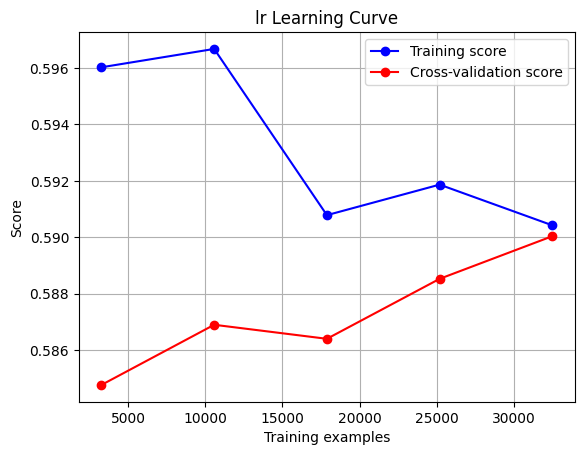

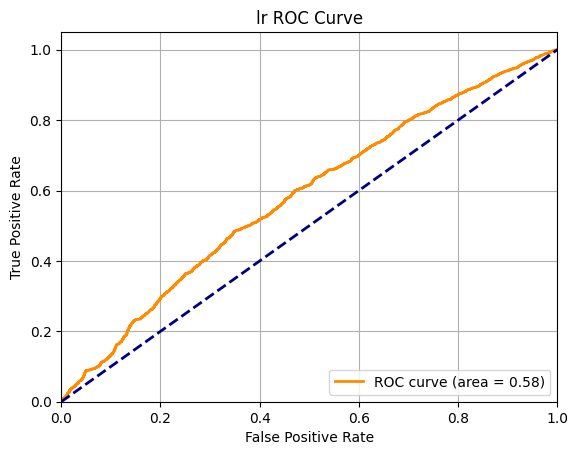

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


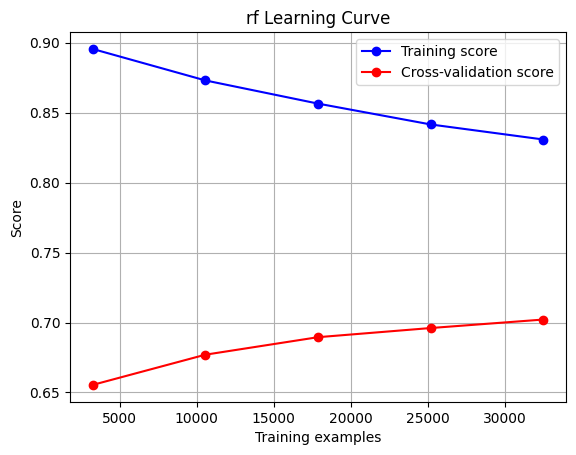

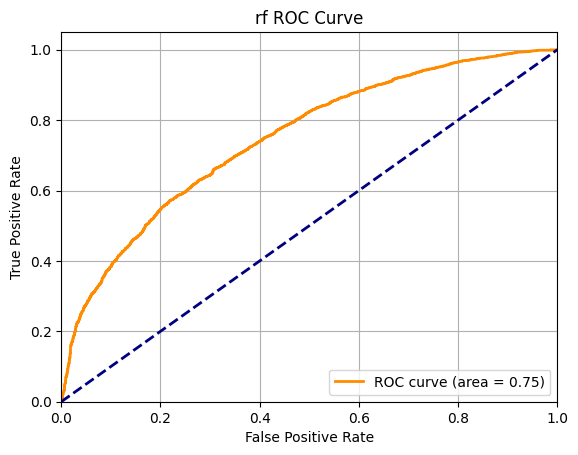

Fitting 5 folds for each of 64 candidates, totalling 320 fits


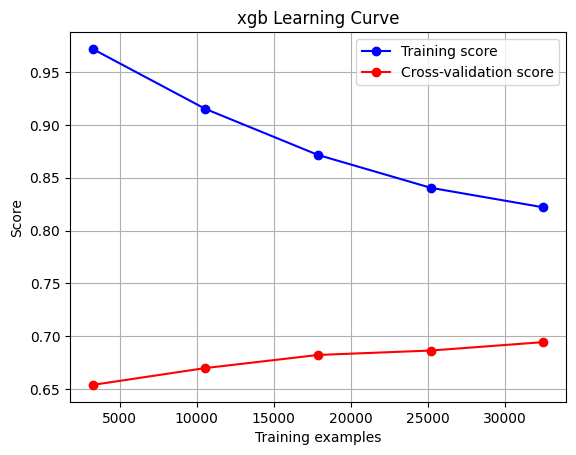

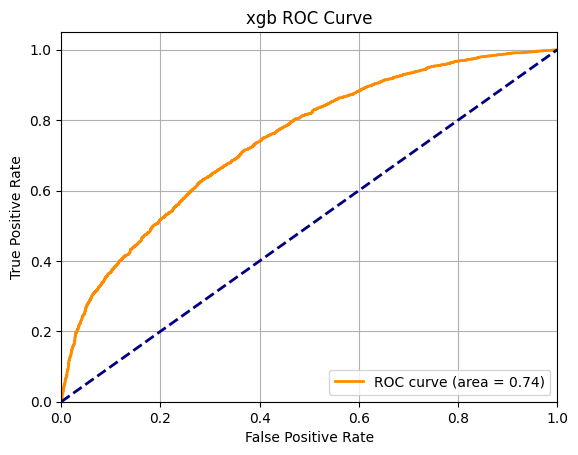

Fitting 5 folds for each of 64 candidates, totalling 320 fits


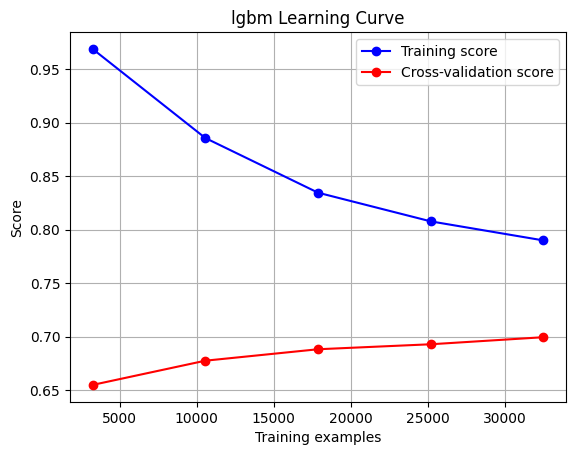

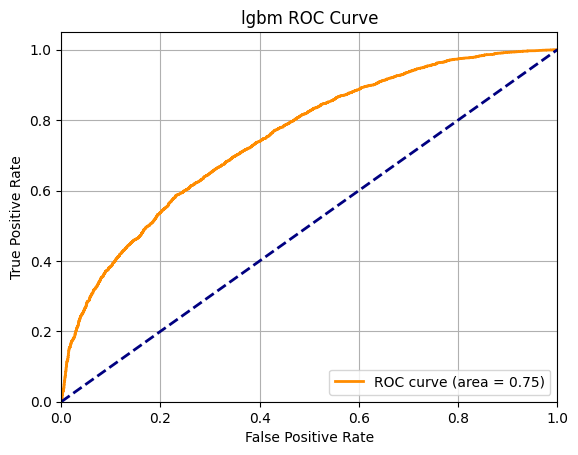

Fitting 5 folds for each of 108 candidates, totalling 540 fits


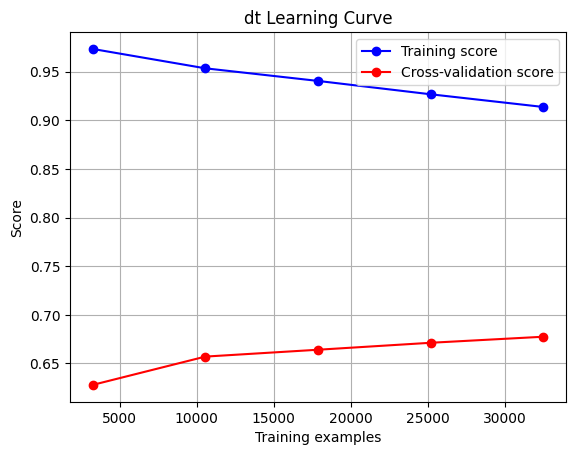

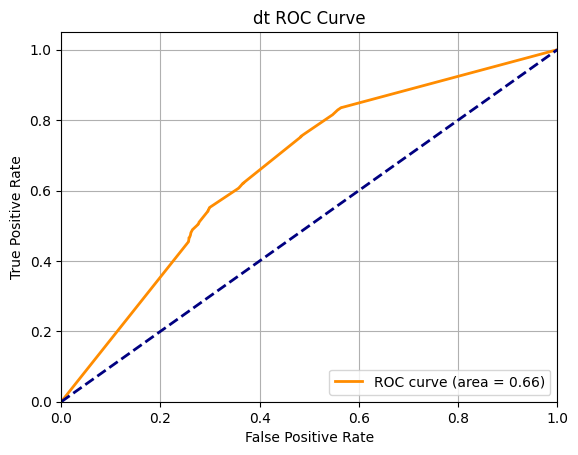

Fitting 5 folds for each of 48 candidates, totalling 240 fits


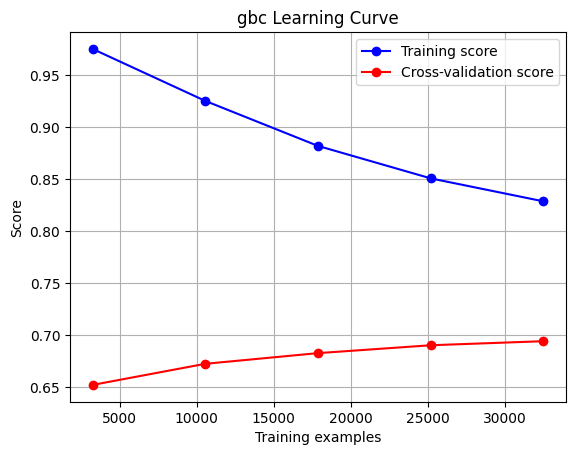

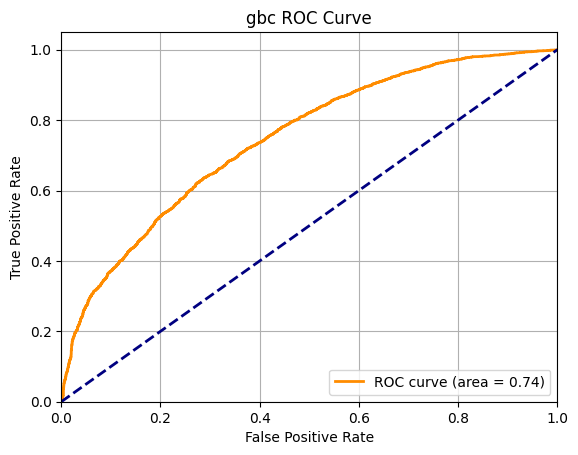

Fitting 5 folds for each of 4 candidates, totalling 20 fits


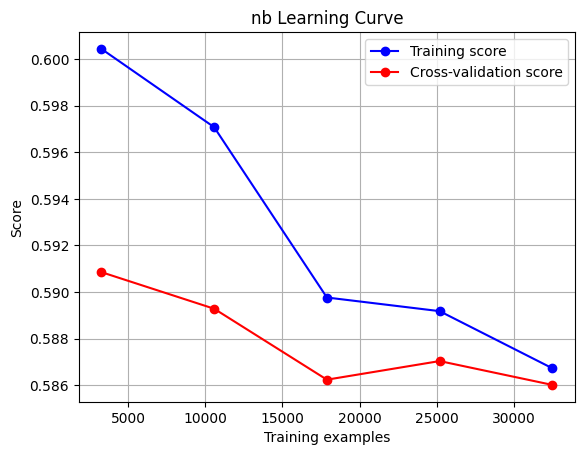

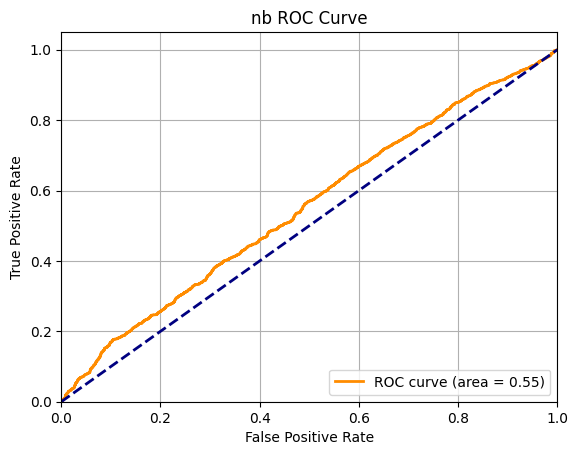

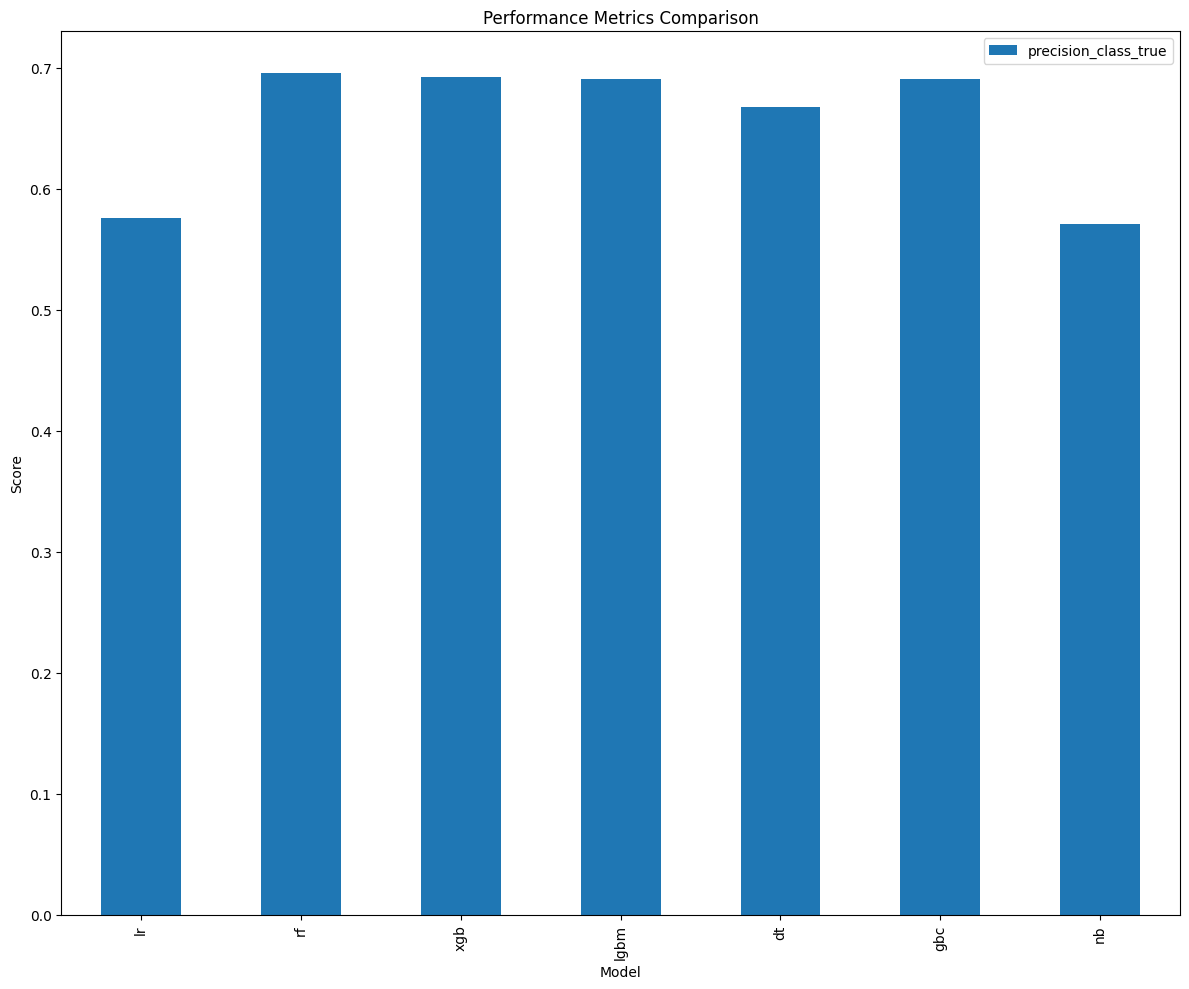

In [104]:
# Commencer le run parent MLflow pour l'expérience globale
with mlflow.start_run(run_name='Model_Comparison_Criticality') as parent_run:
    # Variables pour suivre le meilleur modèle
    best_score = -1
    best_model_name = None
    best_model = None
    results = []


    # Définition des fonctions de score personnalisées pour une utilisation future dans la sélection et l'évaluation des modèles

    # Fonction pour calculer la précision pour la classe "True" spécifiquement.
    # Cette fonction sera utilisée pour créer un scoreur personnalisé adapté à nos besoins d'évaluation spécifiques.
    def precision_score_class_true(y_true, y_pred):
        return precision_score(y_true, y_pred, pos_label=True)  

    # Création d'un scoreur personnalisé à partir de la fonction de précision ci-dessus.
    # Ce scoreur sera utilisé dans GridSearchCV pour optimiser les modèles en fonction de leur précision sur la classe "True".
    # Les scoreurs personnalisés sont essentiels lorsque les métriques d'évaluation standard de scikit-learn
    # ne répondent pas directement à nos besoins spécifiques. Ils permettent d'utiliser n'importe quelle fonction d'évaluation
    # personnalisée dans le cadre de la validation croisée et de l'optimisation des hyperparamètres avec GridSearchCV,
    # offrant ainsi une flexibilité pour se concentrer sur les aspects les plus pertinents de la performance du modèle.
    precision_true_scorer = make_scorer(precision_score_class_true)


    # Fonction pour calculer le F1 score pour la classe "True" spécifiquement.
    # Comme pour la précision, cette fonction sert à évaluer spécifiquement la performance du modèle sur la classe "True".
    def f1_score_class_true(y_true, y_pred):
        return f1_score(y_true, y_pred, pos_label=True)

    # Création d'un scoreur personnalisé pour le F1 score.
    # Utiliser un scoreur personnalisé avec GridSearchCV permet d'aligner étroitement le processus de sélection du modèle
    # avec les objectifs métier ou de recherche, en optimisant les modèles en fonction de métriques qui reflètent le mieux
    # les performances souhaitées dans le contexte d'application réel.
    f1_true_scorer = make_scorer(f1_score_class_true)

    # Boucle sur les modèles pour démarrer des runs enfants
    for model_name, pipeline in pipelines.items():
        # Commencer un run enfant pour chaque modèle
        with mlflow.start_run(run_name=f"{model_name}_model", nested=True):
            
            # Création d'une instance de GridSearchCV avec le pipeline et les paramètres correspondants
            # model = GridSearchCV(pipeline, param_grids[model_name], cv=5, verbose=2, n_jobs=-1, scoring="accuracy", refit=True, return_train_score=True)
            model = GridSearchCV(pipeline, param_grids[model_name], cv=5, verbose=2, n_jobs=-1, scoring=precision_true_scorer, refit=True, return_train_score=True)

            # Entraînement du modèle GridSearchCV sur l'ensemble d'entraînement
            model.fit(X_train, y_train)
            
            # Prédiction sur l'ensemble de test
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]  # Predict probabilities for the positive class
            
            # Calcul de l'accuracy et du recall sur l'ensemble de test
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='macro')  # "macro" pour la precision non pondérée
            recall = recall_score(y_test, y_pred, average='macro')  # "macro" pour le recall non pondéré
            roc_auc = roc_auc_score(y_test, y_pred_proba)  # Calculate AUC-ROC

            # Après avoir sélectionné le meilleur modèle via GridSearchCV, nous calculons des métriques clés
            # pour évaluer sa performance sur l'ensemble de test. Ces métriques incluent la précision et le F1 score pour la classe "True",
            # qui nous fournissent des informations précieuses sur la capacité du modèle à identifier correctement la classe d'intérêt.

            # Calcul de la précision pour la classe "True" spécifiquement.
            # Cette métrique est particulièrement utile pour évaluer la performance du modèle dans la prédiction des cas positifs (erreur).
            precision_class_true = precision_score(y_test, y_pred, pos_label=True)  # Utilisé pour l'évaluation post-entraînement

            # Calcul du F1 score pour la classe "True" spécifiquement.
            # Le F1 score combine la précision et le rappel, offrant une vue d'ensemble de la performance du modèle sur la classe "True".
            f1_class_true = f1_score(y_test, y_pred, pos_label=True)  # Utilisé pour l'évaluation post-entraînement

            # Stockage des résultats dans une liste pour le traçage ultérieur
            results.append({"model": model_name, "accuracy": accuracy, "precision": precision, "recall": recall, "roc_auc": roc_auc,"precision_class_true": precision_class_true,"f1_class_true": f1_class_true})

            # Enregistrement des métriques avec mlflow
            mlflow.log_metric(f"{model_name}_accuracy", accuracy)
            mlflow.log_metric(f"{model_name}_recall", recall)
            mlflow.log_metric(f"{model_name}_roc_auc", roc_auc)
            mlflow.log_metric(f"{model_name}_precision", precision)
            # Enregistrement de la précision de la classe "True" avec MLflow
            mlflow.log_metric(f"{model_name}_precision_class_true", precision_class_true)
            # Enregistrement du F1 score de la classe "True" avec MLflow
            mlflow.log_metric(f"{model_name}_f1_score_class_true", f1_class_true)



            # Génération de la courbe d'apprentissage
            train_sizes, train_scores, test_scores = learning_curve(
                # Extraction du meilleur estimateur du GridSearch pour l'utiliser dans la courbe d'apprentissage
                # model.best_estimator_, X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1,
                model.best_estimator_, X_train, y_train, cv=5, scoring=precision_true_scorer, n_jobs=-1,
                # Génération de tailles de formation linéairement espacées de 10% à 100% de l'ensemble de données
                train_sizes=np.linspace(.1, 1.0, 5))
            # Création d'une nouvelle figure pour le graphique
            plt.figure()
            # Tracé des scores moyens de formation avec des marqueurs et une ligne bleue
            plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='blue', label="Training score")
            # Tracé des scores moyens de validation croisée avec des marqueurs et une ligne rouge
            plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='red', label="Cross-validation score")
            # Ajout d'un titre au graphique avec le nom du modèle
            plt.title(f"{model_name} Learning Curve")
            # Définition des labels des axes
            plt.xlabel("Training examples")
            plt.ylabel("Score")
            # Ajout d'une légende en meilleure position
            plt.legend(loc="best")
            # Activation de la grille sur le graphique pour une meilleure lisibilité
            plt.grid(True)
            # Définition du chemin pour sauvegarder la figure de la courbe d'apprentissage
            learning_curve_path = f"./mlflow_object/{model_name}_learning_curve.png"
            # Sauvegarde de la figure au chemin spécifié
            plt.savefig(learning_curve_path)
            # Affichage de la figure
            plt.show()
            # Fermeture de la figure pour libérer la mémoire
            plt.close()
            
            # Enregistrement de la figure de la courbe d'apprentissage avec mlflow
            mlflow.log_artifact(learning_curve_path)
            
            # Génération de la courbe ROC
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
            # Création d'une nouvelle figure pour le graphique
            plt.figure()
            # Tracé de la courbe ROC avec une ligne orange foncée
            plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
            # Ajout d'une ligne pointillée bleue marine pour la diagonale
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            # Définition des limites de l'axe des abscisses
            plt.xlim([0.0, 1.0])
            # Définition des limites de l'axe des ordonnées
            plt.ylim([0.0, 1.05])
            # Définition des labels des axes
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            # Ajout d'un titre au graphique avec le nom du modèle
            plt.title(f'{model_name} ROC Curve')
            # Ajout d'une légende en bas à droite
            plt.legend(loc="lower right")
            # Activation de la grille sur le graphique pour une meilleure lisibilité
            plt.grid(True)
            # Définition du chemin pour sauvegarder la figure de la courbe ROC
            roc_curve_path = f"./mlflow_object/{model_name}_roc_curve.png"
            # Sauvegarde de la figure au chemin spécifié
            plt.savefig(roc_curve_path)
            # Affichage de la figure
            plt.show()
            # Fermeture de la figure pour libérer la mémoire
            plt.close()
            
            # Enregistrement de la figure de la courbe ROC avec mlflow
            mlflow.log_artifact(roc_curve_path)

            # Mise à jour du meilleur modèle si nécessaire ( pour la precision de la classe True (error))
            if precision_class_true > best_score:  
                best_score = precision_class_true
                best_model_name = model_name
                best_model = model     

            # Mise à jour du meilleur modèle si nécessaire ( pour l'accuracy )
            # if accuracy > best_score:  
            #     best_score = accuracy
            #     best_model_name = model_name
            #     best_model = model            

            # Les runs enfants sont automatiquement terminés ici à la fin du bloc 'with'
                
    # Enregistrement de la métrique du meilleur modèle dans le run parent
    mlflow.log_metric("best_precision_error", best_score)
    if best_model_name:
        mlflow.set_tag("best_model_name", best_model_name)
        mlflow.sklearn.log_model(best_model.best_estimator_, f"best_model_{best_model_name}")

    # Conversion des résultats en DataFrame pour faciliter le traçage
    results_df = pd.DataFrame(results)

    # Prédiction avec le meilleur modèle sur l'ensemble de test
    y_pred_best = best_model.predict(X_test)

    # Calcul du recall général pour le meilleur modèle
    recall_general_best = recall_score(y_test, y_pred_best, average='macro')

    # Génération de la matrice de confusion
    cm = confusion_matrix(y_test, y_pred_best)

    # Classes are simply True and False or 0 and 1
    classes = np.unique(y_test)

    # Création du DataFrame
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)

    # Enregistrement du DataFrame en format CSV
    confusion_matrix_path = "./mlflow_object/confusion_matrix.csv"
    cm_df.to_csv(confusion_matrix_path)
    mlflow.log_artifact(confusion_matrix_path)  # Enregistrement de l'artefact dans MLflow

    # Génération du rapport de classification
    report = classification_report(y_test, y_pred_best, target_names=classes.astype(str))

    classification_report_path = "./mlflow_object/classification_report.txt"
    with open(classification_report_path, "w") as f:
        f.write(report)
    mlflow.log_artifact(classification_report_path) 

    # Sauvegarde du scaler
    scaler_path = './mlflow_object/scaler.joblib'
    dump(scaler, scaler_path)
    mlflow.log_artifact(scaler_path)

    # Enregistrement des exemples d'entrée dans un fichier JSON
    input_example_path = "./mlflow_object/input_exemple.json"
    with open(input_example_path, "w") as f:
        json.dump(example_input_json, f)
    mlflow.log_artifact(input_example_path)

    # Convertir et enregistrer le schéma de sortie dans un fichier JSON
    output_schema_path = "./mlflow_object/output_schema.json"
    with open(output_schema_path, "w") as f:
        json.dump(output_schema, f)
    mlflow.log_artifact(output_schema_path)

    # Enregistrement des hyperparamètres de chaque modèle au format JSON
    hyperparams_path = "./mlflow_object/model_hyperparams_values.json"
    with open(hyperparams_path, "w") as f:
        json.dump(model_hyperparams_values, f)
    mlflow.log_artifact(hyperparams_path)

    # Sauvegarder l'indicateur d'augmentation des données
    mlflow.log_param("data_augmentation", data_augmentation_done)

    # Calcul de la moyenne des trois métriques pour chaque modèle
    # results_df['average'] = results_df[['accuracy', 'recall', 'roc_auc']].mean(axis=1)

    # Tracé des résultats
    fig, ax = plt.subplots(figsize=(12, 10))
    # results_df.plot(kind='bar', x='model', y=['accuracy', 'recall', 'roc_auc', 'average'], ax=ax)
    results_df.plot(kind='bar', x='model', y='precision_class_true', ax=ax)
    ax.set_title('Performance Metrics Comparison')
    ax.set_ylabel('Score')
    ax.set_xlabel('Model')
    plt.tight_layout()
    evaluation_metrics_plot_path = "./mlflow_object/evaluation_metrics_plot.png"
    plt.savefig(evaluation_metrics_plot_path)
    plt.show()
    mlflow.log_artifact(evaluation_metrics_plot_path)

    # Enregistrement des informations du meilleur modèle
    best_model_info_path = "./mlflow_object/best_model_info.json"
    # Affichage du meilleur modèle
    best_model_info = {
        "description": f"Le meilleur modèle de prediction de criticité du run est {best_model_name} avec la metric choisi qui est l'accuracy qui est de {best_score:.3f} pour ce run",
        "params": best_model.best_estimator_.get_params(),
        "params_type": f"{models} (indique la catégorie de paramètres utilisée : 'heavy', 'medium', 'light', ou 'test'. 'Heavy' implique un grand nombre de paramètres, 'medium' un nombre modéré, 'light' un nombre restreint, tandis que 'test' désigne des modèles et hyperparamètres simplifiés pour des tests rapides du pipeline)",
        "scaler used" : scaler_used,
        "sampling_info": sampling_info,
        "test_size_pourcentage" : round(test_size_percentage, 2),
        "X_train_sampling" : str(X_train.shape[0]),
        "y_train_sampling" : str(y_train.shape[0]),
        "X_test_sampling" : str(X_test.shape[0]),
        "y_test_sampling" : str(y_test.shape[0]),
        "gridsearch_details": {
        "cv": 5,
        "scoring_metric": "precision_class_true"
    },"learningcurve_details": {
        "cv": 5,
        "scoring_metric": "precision_class_true"
    },
    "params_choice" : params_choice,
    "miscellaneous note" : ""
    }

    # Conversion de tout objet non sérialisable en chaîne de caractères
    best_model_info["params"] = {k: str(v) for k, v in best_model_info["params"].items()}

    # Enregistrement des informations du meilleur modèle dans un fichier JSON
    best_model_info_path = "./mlflow_object/best_model_info.json"
    with open(best_model_info_path, "w") as f:
        json.dump(best_model_info, f)
    mlflow.log_artifact(best_model_info_path)
        # Convertion du DataFrame en un dictionnaire pour préparer l'enregistrement JSON
    results_dict = results_df.to_dict(orient='records')

    # Restructuration de dictionnaire pour le formatage souhaité
    restructured_dict = {
        model['model']: {
            'accuracy': model['accuracy'],
            'recall': model['recall'],
            'roc_auc': model['roc_auc']
            # 'average': model['average']
        } for model in results_dict
    }

    # Enregistrement des résultats de test des modèles dans un fichier JSON
    results_test_model_path = './mlflow_object/result_test_model.json'
    with open(results_test_model_path, 'w') as f:
        json.dump(restructured_dict, f)
    mlflow.log_artifact(results_test_model_path)

    mlflow.set_tag("params_choice", params_choice)
    mlflow.set_tag("balanced_method", balanced_method)

    
        
    # Le run parent est automatiquement terminé ici à la fin du bloc 'with'

mlflow.end_run()